## Deconvolute human brain layers using Smoother-guided NNLS

In this arbitrary setting, we treat cortical layers as cell types and perform deconvolution to map layer-specific expression programs to spatial locations.

In [1]:
import torch
import numpy as np
import pandas as pd
from smoother import SpatialWeightMatrix, SpatialLoss
from smoother.losses import kl_loss
from smoother.models.deconv import NNLS, NuSVR, DWLS, LogNormReg
import matplotlib.pyplot as plt

### Load the brain cortex dataset (preprocessed)

In [2]:
# change the data directory accordingly
DATA_DIR = "./data/"

# read in log_count matrices
# spatial log-normalized count matrix, num_gene x num_spot
y_df = pd.read_csv(DATA_DIR + "DLPFC_151673_marker_log_exp.txt", sep = " ", header=0)
# per-layer reference matrix, num_gene x num_celltype
x_df = pd.read_csv(DATA_DIR + "DLPFC_151673_marker_log_exp_by_layer.txt", sep = " ", header=0)

# spatial coordinates, num_spot x 2
# here we are using 10x Visium's pixel-level coordinates
# i.e., 'pxl_col_in_fullres' and 'pxl_row_in_fullres'
coords = pd.read_csv(DATA_DIR + "DLPFC_151673_coords.txt", sep = " ", header=0)
coords = coords.loc[y_df.columns,:]

print(f"Number of genes: {y_df.shape[0]}")
print(f"Number of layers: {x_df.shape[1]}")
print(f"Number of spots: {y_df.shape[1]}")

Number of genes: 350
Number of layers: 7
Number of spots: 3639


In [3]:
# convert data into torch tensor
x = torch.tensor(x_df.values).float()
y = torch.tensor(y_df.values).float()

### Generate spatial loss

By default spatial weight matrix is symmetric (a requirement for the CAR and ICAR models).

In [4]:
# calculate spatial weight matrix
weights = SpatialWeightMatrix()
weights.calc_weights_knn(coords, k=6)

# scale the spatial weight matrix by transcriptional similarity
weights.scale_by_expr(y)

# convert spatial weight into loss
# note that the covariance is improper
spatial_loss = SpatialLoss('icar', weights, scale_weights=1)

/Users/jysumac/Projects/Smoother/smoother/weights.py:414: UserWarning: The covariance matrix is not positive definite. you may want to adjust the smoothing parameter l, e.g. in (0, 1).
  warnings.warn(


For optimization tasks it's okay to have improper covariance. If you are seeking a proper prior in a Bayesian setting, simply choose a smaller scale for the loss, e.g.

In [5]:
spatial_loss = SpatialLoss('icar', weights, scale_weights=0.99)

If you want to use SMA or SAR model, we recommend row-scale the spatial weight matrix first for robustness. Note the ISAR model is just the row-scaled version of SAR. 

In [6]:
# calculate spatial weight matrix
weights = SpatialWeightMatrix()
weights.calc_weights_knn(coords, row_scale = True)

# scale the spatial weight matrix by transcriptional similarity
weights.scale_by_expr(y, row_scale = True)

# convert spatial weight into loss
spatial_loss = SpatialLoss('sma', weights, scale_weights=0.999)
# spatial_loss = SpatialLoss('sar', weights, scale_weights=0.999)
spatial_loss = SpatialLoss('isar', weights, scale_weights=0.999)

### Choose model and run deconvolution
Feel free to play around with different models and priors

In [7]:
torch.manual_seed(20221005)

# choose deconvolution model
#model = NuSVR(nu=0.5)
#model = DWLS(nonneg=True, max_weights=4)
#model = LogNormReg()
model = NNLS()

# run deconvolution without spatial loss
model.deconv(x, y, spatial_loss=None, lambda_spatial_loss=0,
             lr=1e-3, tol=1e-6, max_epochs=-1, verbose=False)

# run deconvolution with spatial loss
model_sp = NNLS()
model_sp.deconv(x, y, spatial_loss=spatial_loss, lambda_spatial_loss=10,
                lr=1e-3, tol=1e-6, max_epochs=-1, verbose=False)

=== Time  14.26s. Total epoch 2429. Final loss: (total) 0.253. (spatial) 0.000.
=== Time  20.91s. Total epoch 2383. Final loss: (total) 0.253. (spatial) 0.000.


In [8]:
# extract estimated celltype abundances 
ct_abundances = [m.get_props() for m in [model, model_sp]]
print(ct_abundances[0].shape)

torch.Size([3639, 7])


In [9]:
# compare spatial heterogeneity with and without spatial loss
kl_losses = [kl_loss(torch.nn.functional.softmax(ct_ab.T, dim=0), weights.swm) 
             for ct_ab in ct_abundances]

print(f"Weighted KL-loss: (NNLS): {kl_losses[0]:.4f}, (+ spatial loss): {kl_losses[1]:.4f}")

Weighted KL-loss: (NNLS): 0.0027, (+ spatial loss): 0.0007


### Visualize results

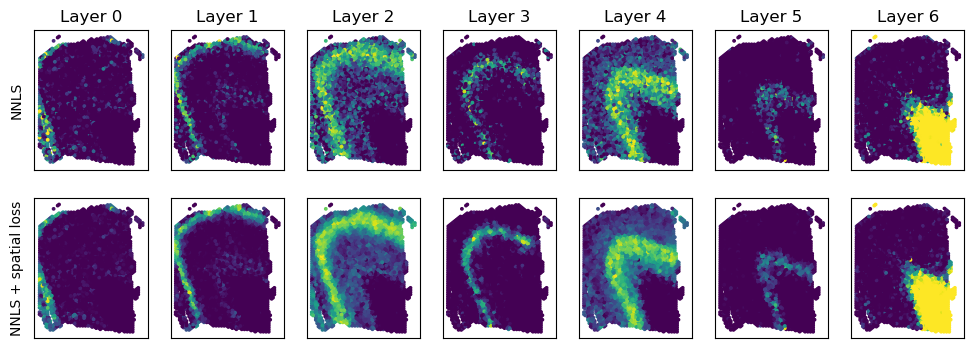

In [10]:
# visualization
# colored by coefficients layer-by-layer
fig, axes = plt.subplots(2, 7, figsize = (12, 4))
for i in range(7):
    axes[0][i].scatter(coords['pxl_col_in_fullres'], coords['pxl_row_in_fullres'], c = ct_abundances[0][:, i], s = 3)
    axes[1][i].scatter(coords['pxl_col_in_fullres'], coords['pxl_row_in_fullres'], c = ct_abundances[1][:, i], s = 3)
    
    axes[0][i].set_title(f"Layer {i}")

for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

axes[0][0].set_ylabel('NNLS')
axes[1][0].set_ylabel('NNLS + spatial loss')

plt.show()

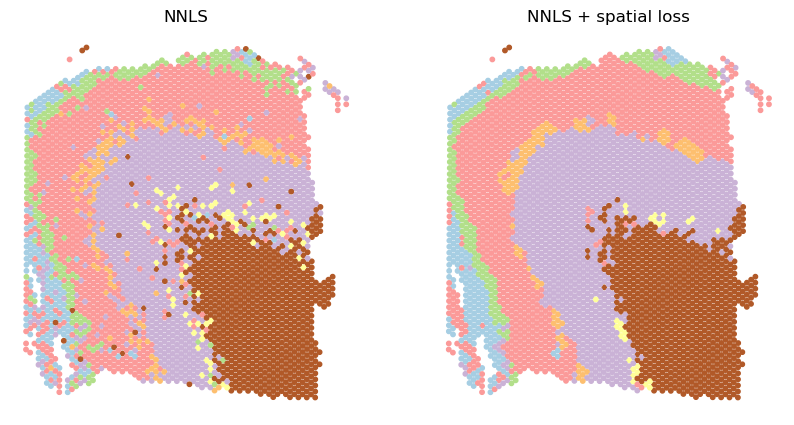

In [11]:
# colored by max coefficient
fig, (ax1, ax2)= plt.subplots(1, 2, figsize = (10, 5))
ax1.scatter(coords['pxl_col_in_fullres'], coords['pxl_row_in_fullres'], 
            c = ct_abundances[0].argmax(dim=1), s = 10, cmap='Paired')
ax2.scatter(coords['pxl_col_in_fullres'], coords['pxl_row_in_fullres'], 
            c = ct_abundances[1].argmax(dim=1), s = 10, cmap='Paired')

ax1.set_title('NNLS')
ax2.set_title('NNLS + spatial loss')
ax1.axis('off')
ax2.axis('off')

plt.show()

### (Optional) Solve deconvolution models using convex optimization

Make sure CVXPY is installed

In [12]:
# calculate spatial weight matrix
weights = SpatialWeightMatrix()
weights.calc_weights_knn(coords, k=6)

# scale the spatial weight matrix by transcriptional similarity
weights.scale_by_expr(y)
spatial_loss = SpatialLoss('icar', weights, scale_weights=0.99, standardize_cov=True)

# select model and run deconvolution
model = NNLS(backend='cvxpy')
#model = DWLS(backend='cvxpy', max_weights=4)
#model = NuSVR(backend='cvxpy', nonneg=True)
model.deconv(x, y, spatial_loss=None, lambda_spatial_loss=0)

#model_sp = LinearRegression(backend='cvxpy')
model_sp = NNLS(backend='cvxpy')
#model_sp = DWLS(backend='cvxpy', max_weights=4)
#model_sp = NuSVR(backend='cvxpy', nonneg=True)
model_sp.deconv(x, y, spatial_loss, lambda_spatial_loss=10)

=== Time  9.23s. Loss: (total)  0.252, (model)  0.252, (spatial)  0.000
=== Time  14.06s. Loss: (total)  0.253, (model)  0.253, (spatial)  0.001


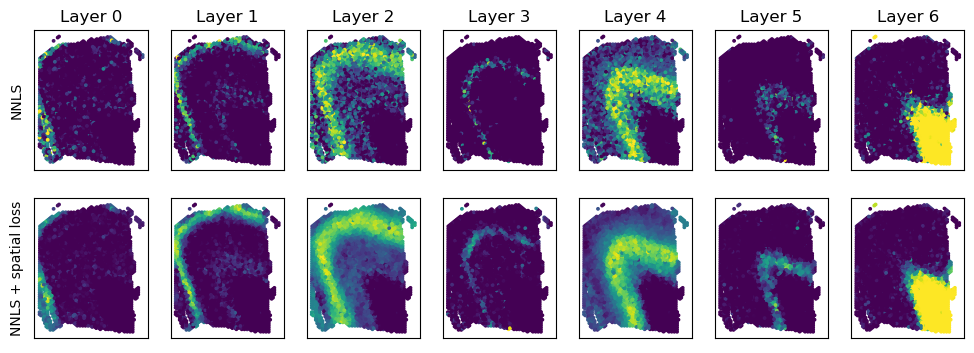

In [13]:
# visualization
# colored by coefficients layer-by-layer
fig, axes = plt.subplots(2, 7, figsize = (12, 4))
for i in range(7):
    axes[0][i].scatter(coords['pxl_col_in_fullres'], coords['pxl_row_in_fullres'],
                       c = model.get_props()[:, i], s = 3)
    axes[1][i].scatter(coords['pxl_col_in_fullres'], coords['pxl_row_in_fullres'],
                       c = model_sp.get_props()[:, i], s = 3)
    
    axes[0][i].set_title(f"Layer {i}")

for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

axes[0][0].set_ylabel('NNLS')
axes[1][0].set_ylabel('NNLS + spatial loss')

plt.show()

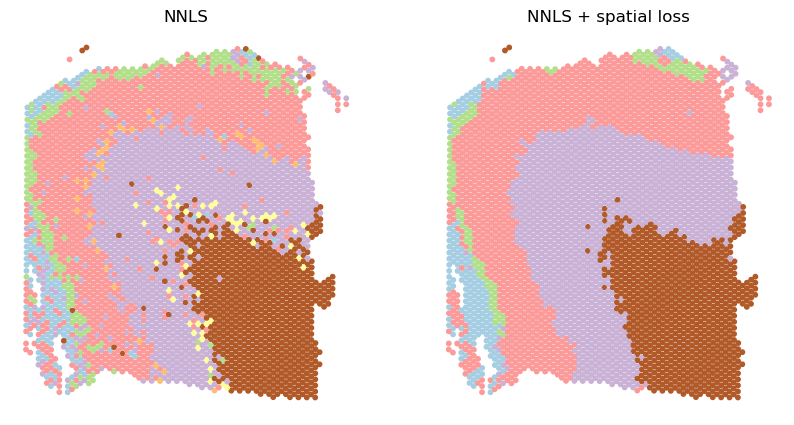

In [14]:
# colored by max coefficient
fig, (ax1, ax2)= plt.subplots(1, 2, figsize = (10, 5))
ax1.scatter(coords['pxl_col_in_fullres'], coords['pxl_row_in_fullres'], 
            c = model.get_props().argmax(axis=1), s = 10, cmap='Paired')
ax2.scatter(coords['pxl_col_in_fullres'], coords['pxl_row_in_fullres'], 
            c = model_sp.get_props().argmax(axis=1), s = 10, cmap='Paired')

ax1.set_title('NNLS')
ax2.set_title('NNLS + spatial loss')
ax1.axis('off')
ax2.axis('off')

plt.show()

### (Optional) Solve deconvolution models using convex optimization with warm start

Warm start allows the fine-tuning of hyperparameters, in this case the smoothing strength lambda_sp

In [15]:
# calculate spatial weight matrix
weights = SpatialWeightMatrix()
weights.calc_weights_knn(coords, k=6)

# scale the spatial weight matrix by transcriptional similarity
weights.scale_by_expr(y)
spatial_loss = SpatialLoss('icar', weights, scale_weights=0.99, standardize_cov=True)

props = []
lambda_sp_losses = [0, 1, 3, 10]

model = NNLS(backend='cvxpy', bias=True)
# if models only differ by lambda_spatial_loss,
# will enable warm start to speed up computation
for l_sp_loss in lambda_sp_losses:
    model.deconv(x, y, spatial_loss, lambda_spatial_loss=l_sp_loss)
    props.append(model.get_props())

=== Time  13.57s. Loss: (total)  0.252, (model)  0.252, (spatial)  0.000
=== Time  6.42s. Loss: (total)  0.252, (model)  0.252, (spatial)  0.000
=== Time  5.28s. Loss: (total)  0.253, (model)  0.252, (spatial)  0.000
=== Time  5.17s. Loss: (total)  0.253, (model)  0.253, (spatial)  0.001


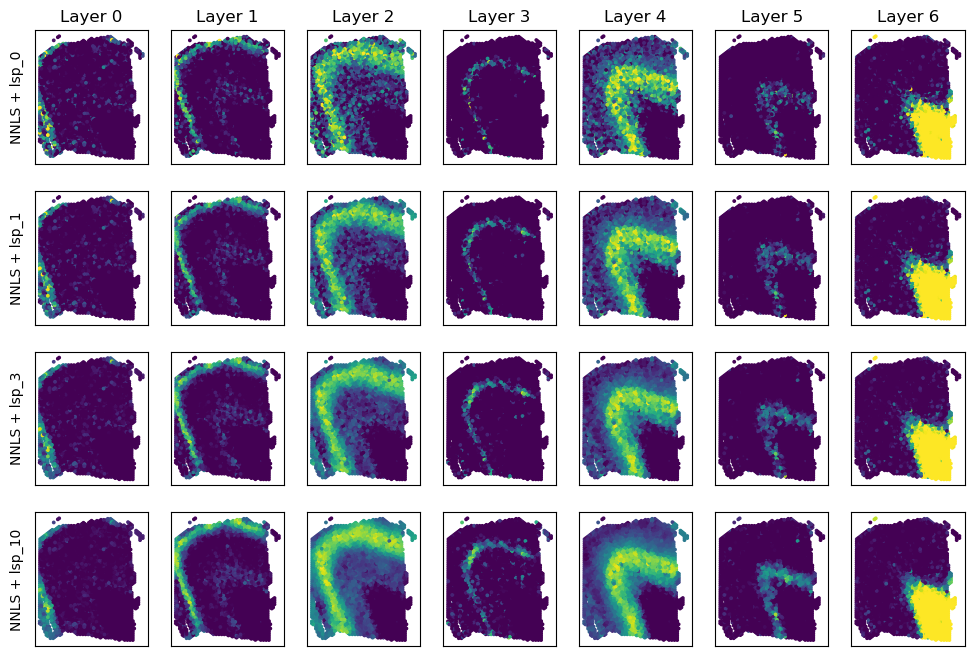

In [16]:
# visualization
# colored by coefficients layer-by-layer
fig, axes = plt.subplots(4, 7, figsize = (12, 8))
for i in range(7):
    for j, l_sp_loss in enumerate(lambda_sp_losses):
        axes[j][i].scatter(coords['pxl_col_in_fullres'], coords['pxl_row_in_fullres'],
                           c = props[j][:, i], s = 3)
    
    axes[0][i].set_title(f"Layer {i}")

for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

for j, l_sp_loss in enumerate(lambda_sp_losses):
    axes[j][0].set_ylabel(f'NNLS + lsp_{l_sp_loss}')

plt.show()